<a href="https://colab.research.google.com/github/halcy/LearningJAX/blob/main/JAX_Day_1_Morning_MNIST_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JAX Day 1 - Morning - MNIST Digits classifier

This is a simple notebook to train a basic MNIST digits classifier with around 98% accuracy, using JAX on a single TPU device. This is about the most basic example that actually does anything that I can think of.

In [ ]:
# Catchall "what is this runtime" cell
!nvidia-smi
GPU = !nvidia_smi

if len(GPU) > 3:
    GPU = True
else:
    GPU = False

!vmstat
print("")

import os

if "COLAB_TPU_ADDR" in os.environ:
    from tensorflow.python.profiler import profiler_client
    print("tpu:", os.environ['COLAB_TPU_ADDR'])
    tpu_profile_service_address = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466')
    print(profiler_client.monitor(tpu_profile_service_address, 100, 2).strip())
    TPU = True
else:
    print("tpu: no")
    TPU = False

CPUS = os.cpu_count()
print("\ncpus:", CPUS)

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

procs -----------memory---------- ---swap-- -----io---- -system-- ------cpu-----
 r  b   swpd   free   buff  cache   si   so    bi    bo   in   cs us sy id wa st
 0  0      0 10669724 102316 2035320    0    0  1413    31  233  490  3  2 94  1  0

tpu: 10.6.191.242:8470
Timestamp: 16:56:23
  TPU type: TPU v2
  Utilization of TPU Matrix Units (higher is better): 0.000%

cpus: 2


# Basic setup and data loading

This sets up the environment for JAX to run on a TPU, sets up the PRNG state that JAX, being a pure (i.e. no side effects) function composition library makes you drag along when needed, and grabs a copy of the MNIST digits dataset.

We use the following libraries with JAX:
* Haiku - a neural network definition library with primitives for things like conv nets and batch normalization
* Optax - A library with optimizers

In [ ]:
# Set JAX, haiku and optax up for the TPU
!pip install --upgrade -q jax jaxlib dm-haiku optax tqdm

import requests
import os

if 'TPU_DRIVER_MODE' not in globals():
    url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
    resp = requests.post(url)
    TPU_DRIVER_MODE = 1

# TPU driver as backend for JAX
from jax.config import config
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']

     |████████████████████████████████| 708 kB 7.1 MB/s 
     |████████████████████████████████| 284 kB 17.1 MB/s 
     |████████████████████████████████| 118 kB 18.4 MB/s 
     |████████████████████████████████| 76 kB 3.9 MB/s 
     |████████████████████████████████| 57 kB 5.0 MB/s 


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
from jax import jit, nn

import haiku as hk
import optax

import tqdm

In [ ]:
# Generate PRNG state
prng = jax.random.PRNGKey(23)

In [ ]:
# Lets get MNIST
import tensorflow_datasets as tfds

data_dir = '/tmp/tfds'

# Fetch full datasets for evaluation
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_labels = nn.one_hot(train_labels, num_labels)
train_images = train_images.astype(jnp.float32)

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_labels = nn.one_hot(test_labels, num_labels)
test_images = test_images.astype(jnp.float32)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /tmp/tfds/mnist/3.0.1. Subsequent calls will reuse this data.


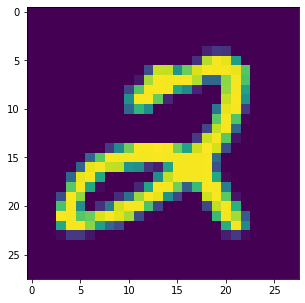

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(test_images[0,:,:,0], interpolation=None)

# Network setup

Set up the network. The basic network shape here is "some sort of resnet", no guarantees that this is sensible at all. Some notes:

* Note how we call hk.transform_with_state to instantiate our network? What this does is take the network, and return a named tuple of two pure functions. First, .init, which returns the initial parameters and state (hence, _with_state - needed for the batch normalization, in our case) and params. Second, .apply, which takes parameters, state, PRNG state and input data, and returns whatever our network returns.
* The Optax optimizer is similar, .init gives optimizer parameters, .update returns updated network parameters and optimizer state given gradients.

In [ ]:
# Lets define a network
class ResBlock(hk.Module):
    def __call__(self, x):
        conv1 = hk.Conv2D(7, (3, 3))
        conv2 = hk.Conv2D(5, (5, 5))
        conv3 = hk.Conv2D(1, (7, 7))
        
        x_in = x
        x = jax.nn.relu(conv1(x))
        x = jax.nn.relu(conv2(x))
        x = jax.nn.relu(conv3(x))
        x = hk.max_pool(x, (1, 3, 3, 1), 1, 'SAME')
        x = x - x_in

        return x + w

# "idk, a resnet?"
def network(x, is_training):
    block1 = ResBlock()
    bn1 = hk.BatchNorm(True, True, 0.999)

    block2 = ResBlock()
    bn2 = hk.BatchNorm(True, True, 0.999)
    
    block3 = ResBlock()
    bn3 = hk.BatchNorm(True, True, 0.999)
    
    project = hk.Linear(num_labels)
    x = block1(x)
    x = bn1(x, is_training)

    x = block2(x)
    x = bn2(x, is_training)

    x = block3(x)
    x = bn3(x, is_training)

    x = x.reshape(-1, num_pixels)
    x = project(x)
    return x

In [ ]:
# Some parameters
batch_size = 1024
learning_rate = 0.0001
train_epochs = 50

In [ ]:
# Construct a model and optimizer
model = hk.transform_with_state(network)
opt = optax.chain(
    optax.scale_by_adam(b1=0.9, b2=0.999, eps=1e-8),
    optax.scale(-learning_rate)
)

In [ ]:
# Init model and optimizer parameters
params, state = model.init(prng, train_images[:1, :, :, :], is_training = True)
opt_params = opt.init(params)

In [ ]:
# Define a loss function
def loss_fn(params, state, x, y):
    x, state = model.apply(params, state, None, x, is_training=True)
    x = nn.log_softmax(x)
    loss = -jnp.mean(x * y)
    return loss, (loss, state)

# Train

Finally, we can train. We could just run this directly without jit-ing, but that would be somewhat slow. Instead, we can jit - and we can do so at various different levels, eother just the evaluation of the loss function, or a whole update step - or even a complete unrolled epoch!

In [ ]:
# You could jit just the loss function...
# loss_fn = jit(loss_fn)

def train_step(params, state, opt_params, x, y):
    grad, (loss, state) = jax.grad(loss_fn, has_aux=True)(params, state, x, y)
    updates, opt_params = opt.update(grad, opt_params, params)
    params = optax.apply_updates(params, updates)
    return params, state, opt_params, loss

# Or jit a step (this is likely the most sensible thing)...
train_step = jit(train_step)

def train_epoch(params, state, opt_params):
    losses = []
    for batch in jnp.arange(0, len(train_images), batch_size):
        x = train_images[batch:batch+batch_size,:,:,:]
        y = train_labels[batch:batch+batch_size,:]
        params, state, opt_params, loss = train_step(params, state, opt_params, x, y)
        losses.append(loss)
    return params, state, opt_params, losses

# Or an entire unrolled epoch (bad idea, generally, huge memory / compilation time sink)
#train_epoch = jit(train_epoch)

for step in range(train_epochs):
    losses = []
    params, state, opt_params, losses = train_epoch(params, state, opt_params)
    print("e:", step, "l:", np.mean(losses))

e: 0 l: 0.21341863
e: 1 l: 0.13839717
e: 2 l: 0.09467633
e: 3 l: 0.06623664
e: 4 l: 0.04847922
e: 5 l: 0.038238954
e: 6 l: 0.031417634
e: 7 l: 0.026573995
e: 8 l: 0.023100587
e: 9 l: 0.020549478
e: 10 l: 0.01864132
e: 11 l: 0.01715308
e: 12 l: 0.015959896
e: 13 l: 0.014973958
e: 14 l: 0.014143918
e: 15 l: 0.0134232445
e: 16 l: 0.012801917
e: 17 l: 0.012251562
e: 18 l: 0.011766247
e: 19 l: 0.011325394
e: 20 l: 0.010928549
e: 21 l: 0.0105622085
e: 22 l: 0.010232149
e: 23 l: 0.009928647
e: 24 l: 0.009641716
e: 25 l: 0.00937583
e: 26 l: 0.009128608
e: 27 l: 0.008890614
e: 28 l: 0.008670028
e: 29 l: 0.008472329
e: 30 l: 0.008278087
e: 31 l: 0.008097707
e: 32 l: 0.007926204
e: 33 l: 0.0077711716
e: 34 l: 0.0076172613
e: 35 l: 0.007475287
e: 36 l: 0.007337143
e: 37 l: 0.007203609
e: 38 l: 0.0070745833
e: 39 l: 0.006956692
e: 40 l: 0.0068435115
e: 41 l: 0.0067292163
e: 42 l: 0.006618696
e: 43 l: 0.006517505
e: 44 l: 0.006415152
e: 45 l: 0.0063130925
e: 46 l: 0.006220402
e: 47 l: 0.006124385
e:

# Evaluation
Finally, lets just calculate test set accuracy.

In [ ]:
test_pred, _ = model.apply(params, state, None, test_images, is_training=False)

In [ ]:
print("accuracy:", np.mean((np.argmax(test_pred, axis = -1) - np.argmax(test_labels, axis = -1)) == 0))

accuracy: 0.9788


# Next up
This afternoon, lets learn how to run things on more than one TPU device!